# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.  

А именно: 
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами

# Описание данных

- Данные клиента за предыдущий до проверки факта оттока месяц:
  - '`gender`' — пол;
  - '`Near_Location`' — проживание или работа в районе, где находится фитнес-центр;
  - '`Partner`' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
  - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
  - '`Phone`' — наличие контактного телефона;
  - '`Age`' — возраст;
  - '`Lifetime`' — время с момента первого обращения в фитнес-центр (в месяцах).
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
  - '`Contract_period`' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
  - '`Month_to_end_contract`' — срок до окончания текущего действующего абонемента (в месяцах);
  - '`Group_visits`' — факт посещения групповых занятий;
  - '`Avg_class_frequency_total`' — средняя частота посещений в неделю за все время с начала действия абонемента;
  - '`Avg_class_frequency_current_month`' — средняя частота посещений в неделю за предыдущий месяц;
  - '`Avg_additional_charges_total`' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- '`Churn`' — факт оттока в текущем месяце.

# Оглавление

1. [Загрузка данных](#start)
2. [Анализ данных](#eda)
3. [Модель прогнозирования оттока клиентов](#model)
4. [Кластеризация клиентов](#cluster)
5. [Выводы и рекомендации](#conclusion)

<a id="start"></a>
# Загрузка данных

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# зададим стиль по-умолчанию для графиков
plt.style.use('ggplot')

In [2]:
# библиотеки для машинного обучения

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools 



In [3]:
# Избавиться от экспоненты
pd.options.display.float_format = '{:,.1f}'.format

In [4]:
# загружаем CSV-файлы с данными и сохраняем их в датафреймы
try:
    gym_churn = pd.read_csv('/datasets/gym_churn.csv')
except:
    gym_churn = pd.read_csv('../datasets/gym_churn.csv')

<a id="eda"></a>
# Исследовательский анализ данных (EDA)

- Посмотрим на датасет: есть ли в нём отсутствующие значения (пропуски), изучим средние значения и стандартные отклонения;
- Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (методом groupby());
- Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
- Построим матрицу корреляций и отобразим её.

In [5]:
# Зададим функцию для исследовательского анализа данных
def perform_eda(dataframe):
    """
    Производит исследовательский анализ данных (EDA) переданного датафрейма.
    
    Параметры:
    dataframe (pd.DataFrame): DataFrame для анализа.
    """
    
    # Основная информация
    print("Основная информация:")
    display(dataframe.head())
    display(dataframe.info())
    
    # Сводная статистика для числовых столбцов
    print("\nСводная статистика для числовых столбцов:")
    display(dataframe.describe())
    
    # Сводная статистика для категориальных столбцов
    print("\nСводная статистика для категориальных столбцов:")
    try:
        # Попытка отобразить описательную статистику для категориальных столбцов.
        display(dataframe.describe(include='object'))
    except ValueError as e:
        # Обрабатываем ошибку "No objects to concatenate" 
        print("В DataFrame не найдено категориальных столбцов.")
        pass
    
    # Пропуски
    print("\nПропущенные значения:")
    missing_values = dataframe.isnull().sum()
    missing_percentage = (missing_values / len(dataframe)) * 100
    missing_info = pd.DataFrame({'Пропуски': missing_values, 'Доля': missing_percentage})
    display(missing_info)
    
    # Дубликаты
    print("\nДубликаты:")
    duplicated_rows = dataframe[dataframe.duplicated()]
    display(duplicated_rows)
    
    # Типы данных
    print("\nТипы данных:")
    display(dataframe.dtypes)
    
    # Уникальные значения категориальных столбцов
    print("\nУникальные значения категориальных столбцов:")
    categorical_columns = dataframe.select_dtypes(include='object').columns
    for column in categorical_columns:
        unique_counts = dataframe[column].value_counts()
        if len(unique_counts) <= 10:
            print(f"{column}:\n")
            display(unique_counts)
    
    # Визуализация
    print("\nВизуализация:")
    numerical_columns = dataframe.select_dtypes(include=np.number).columns
    for column in numerical_columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(dataframe[column], kde=True)
        plt.title(f'Распределение {column}')
        plt.show()

Основная информация:


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.2,5.0,3,0.0,0.0,0
1,0,1,0,0,1,12,1,31,113.2,12.0,7,1.9,1.9,0
2,0,1,1,0,1,1,0,28,129.4,1.0,2,1.9,1.7,0
3,0,1,1,1,1,12,1,33,62.7,12.0,2,3.2,3.4,0
4,1,1,1,1,1,1,0,26,198.4,1.0,3,1.1,1.1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

None


Сводная статистика для числовых столбцов:


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.0","4,000.0","4,000.0","4,000.0","4,000.0","4,000.0","4,000.0","4,000.0","4,000.0","4,000.0","4,000.0","4,000.0","4,000.0","4,000.0"
mean,0.5,0.8,0.5,0.3,0.9,4.7,0.4,29.2,146.9,4.3,3.7,1.9,1.8,0.3
std,0.5,0.4,0.5,0.5,0.3,4.5,0.5,3.3,96.4,4.2,3.7,1.0,1.1,0.4
min,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.0,0.1,1.0,0.0,0.0,0.0,0.0
25%,0.0,1.0,0.0,0.0,1.0,1.0,0.0,27.0,68.9,1.0,1.0,1.2,1.0,0.0
50%,1.0,1.0,0.0,0.0,1.0,1.0,0.0,29.0,136.2,1.0,3.0,1.8,1.7,0.0
75%,1.0,1.0,1.0,1.0,1.0,6.0,1.0,31.0,210.9,6.0,5.0,2.5,2.5,1.0
max,1.0,1.0,1.0,1.0,1.0,12.0,1.0,41.0,552.6,12.0,31.0,6.0,6.1,1.0



Сводная статистика для категориальных столбцов:
В DataFrame не найдено категориальных столбцов.

Пропущенные значения:


,Пропуски,Доля
gender,0,0.0
near_location,0,0.0
partner,0,0.0
promo_friends,0,0.0
phone,0,0.0
contract_period,0,0.0
group_visits,0,0.0
age,0,0.0
avg_additional_charges_total,0,0.0
month_to_end_contract,0,0.0



Дубликаты:


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn



Типы данных:


gender                                 int64
near_location                          int64
partner                                int64
promo_friends                          int64
phone                                  int64
contract_period                        int64
group_visits                           int64
age                                    int64
avg_additional_charges_total         float64
month_to_end_contract                float64
lifetime                               int64
avg_class_frequency_total            float64
avg_class_frequency_current_month    float64
churn                                  int64
dtype: object


Уникальные значения категориальных столбцов:

Визуализация:


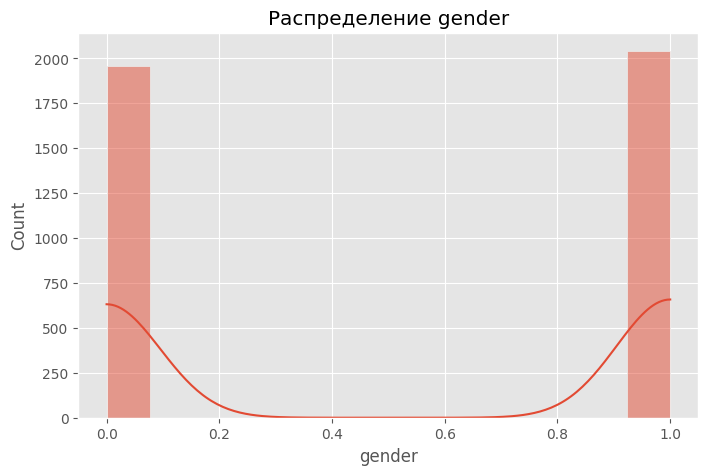

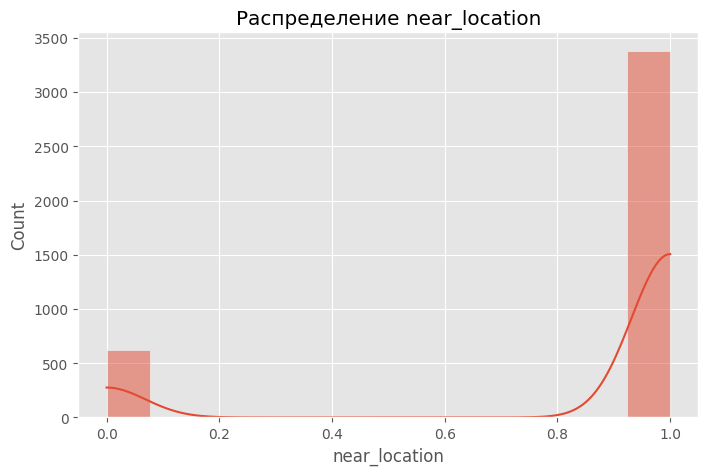

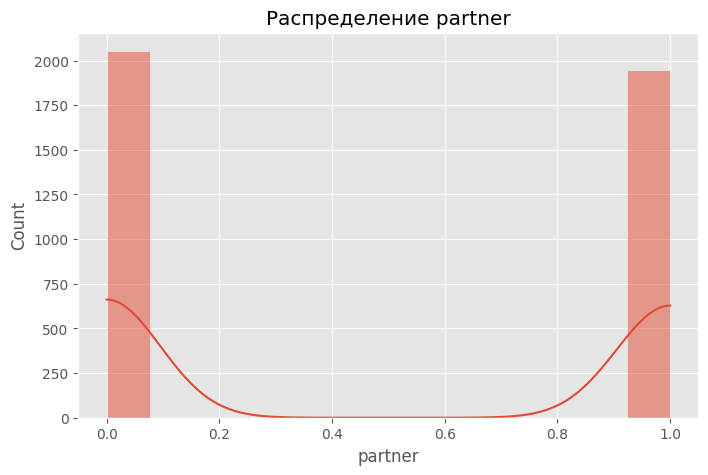

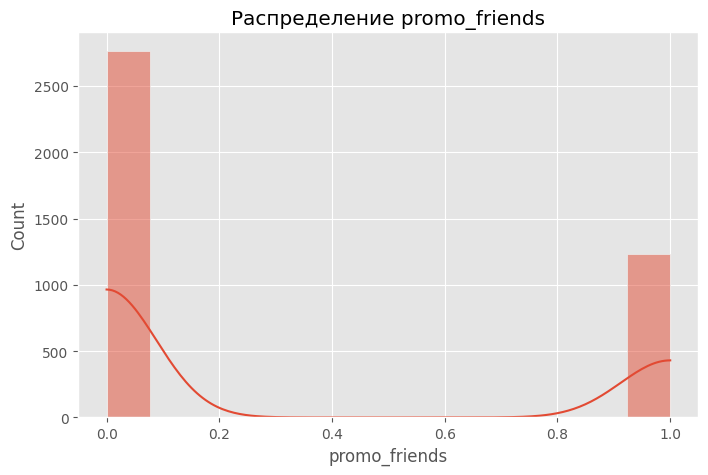

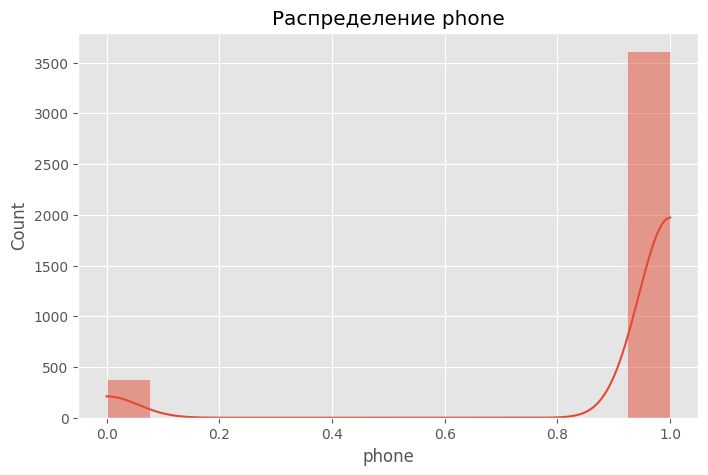

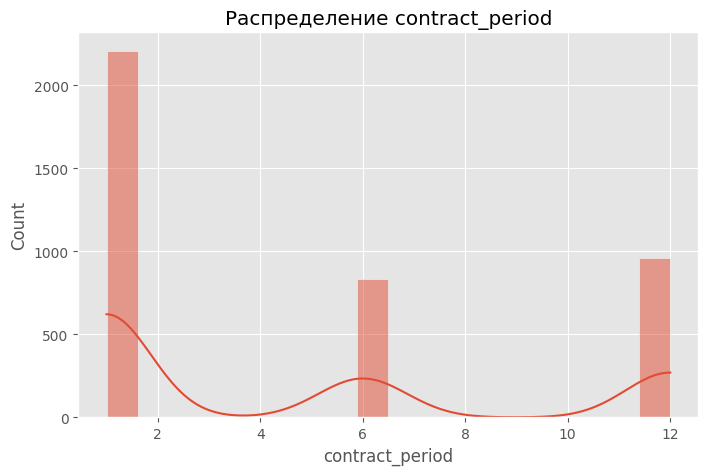

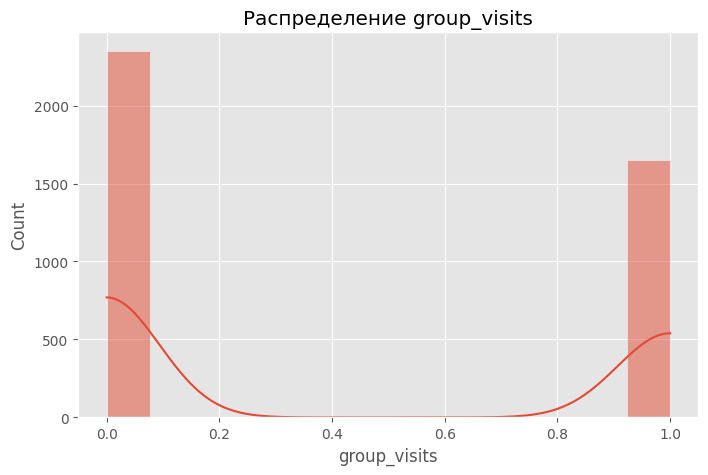

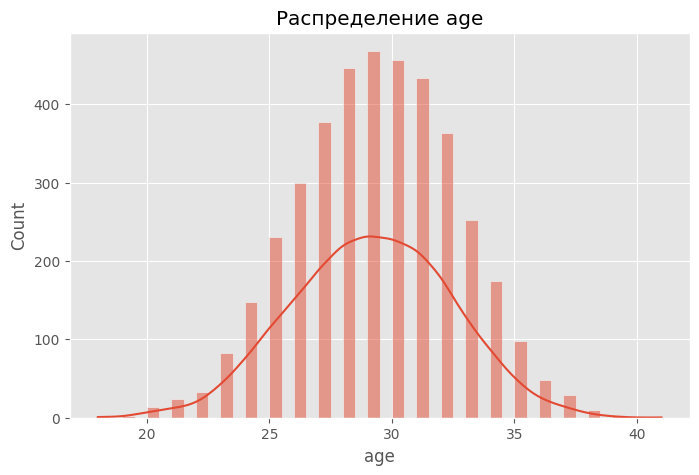

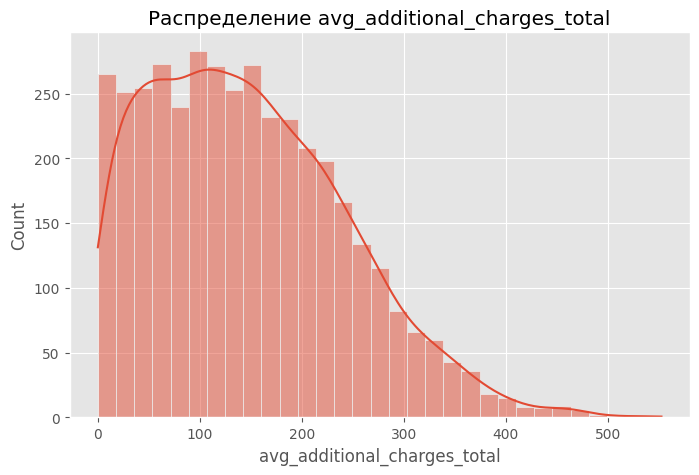

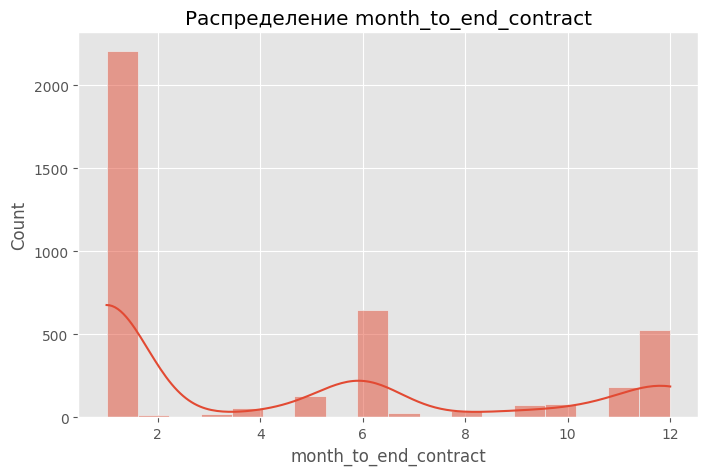

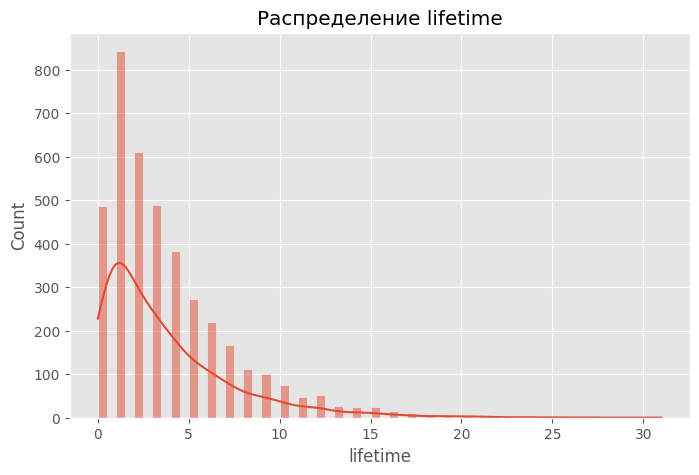

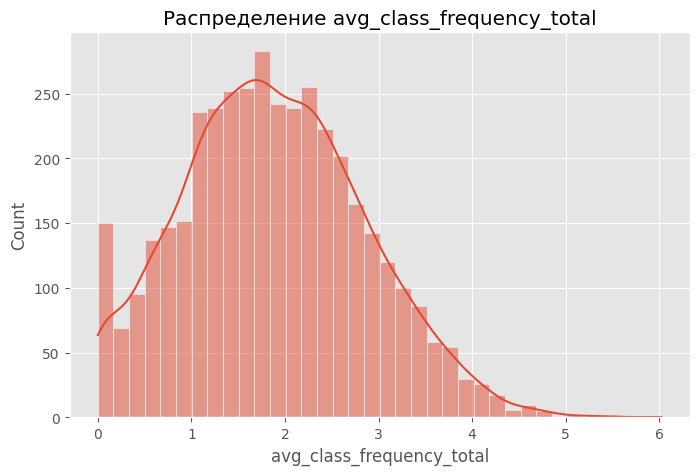

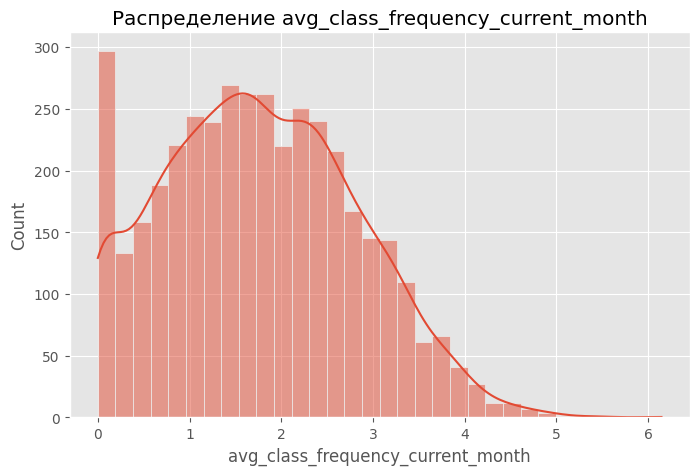

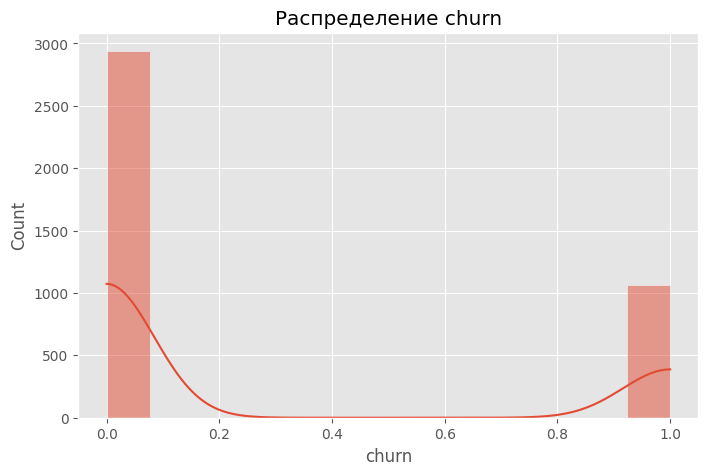

In [6]:
# приведём названия столбцов к нижнему регистру
gym_churn.columns = map(str.lower, gym_churn.columns)

# посмотрим на данные с помощью функции EDA
perform_eda(gym_churn)

In [7]:
# Посмотрим на средние значения признаков в двух группах 
# — тех, кто ушел в отток и тех, кто остался (методом groupby());
gym_churn.groupby(by='churn').agg('median')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,1.0,1.0,1.0,0.0,1.0,6.0,0.0,30.0,149.9,6.0,4.0,2.0,2.0
1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,27.0,103.8,1.0,1.0,1.5,1.0


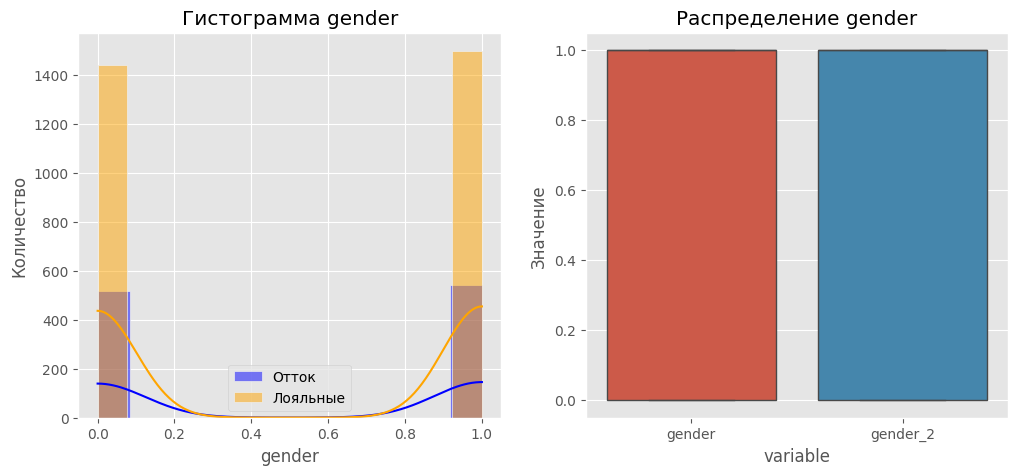

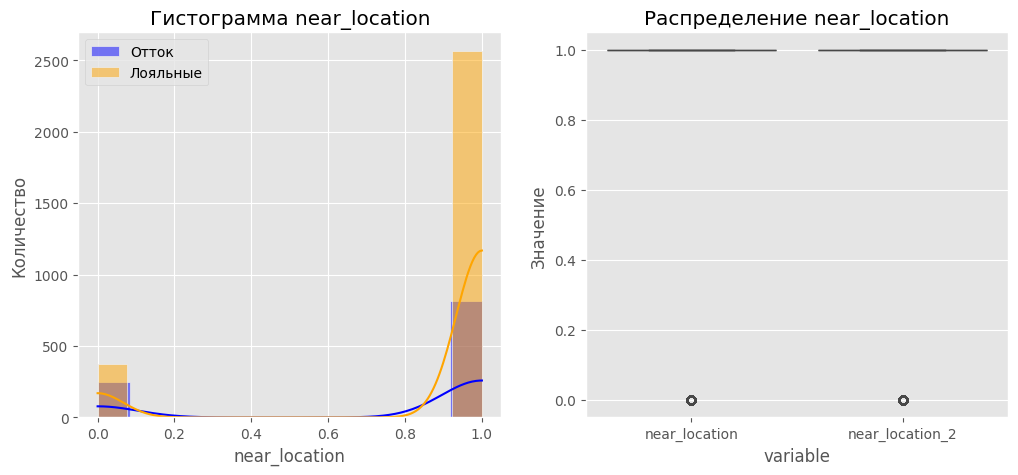

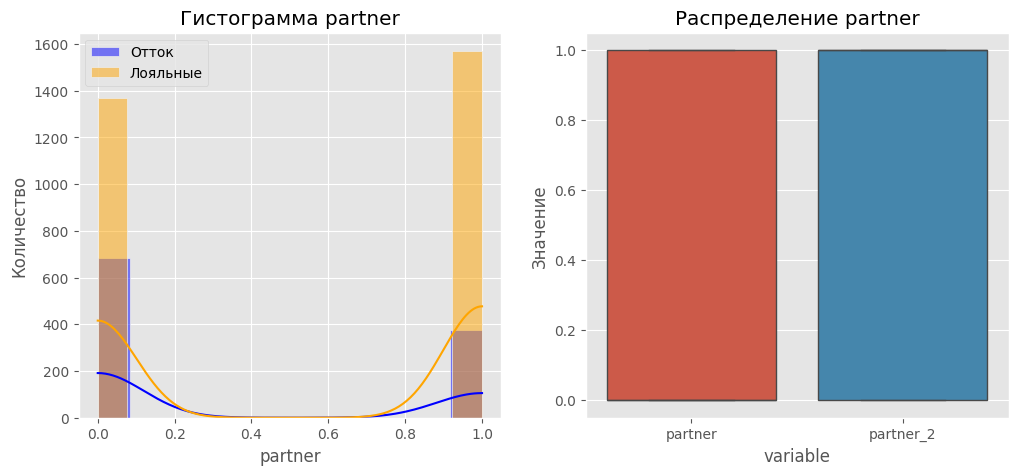

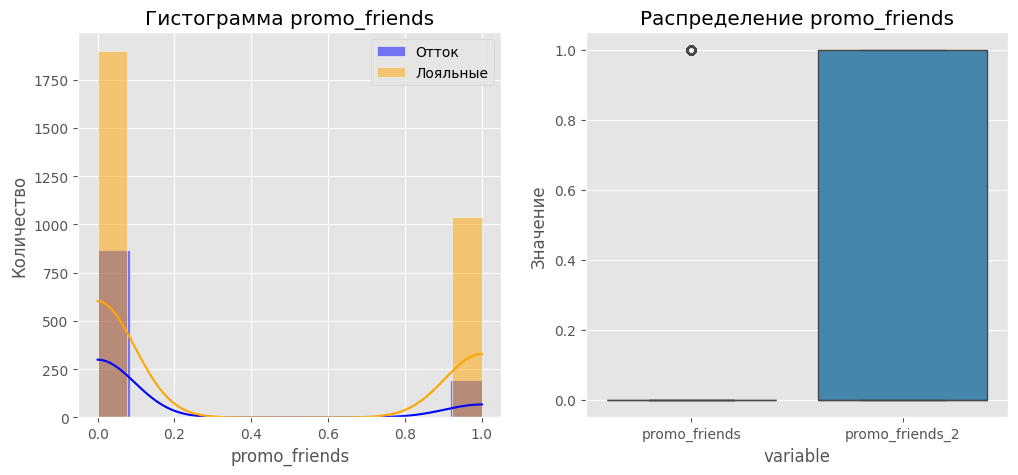

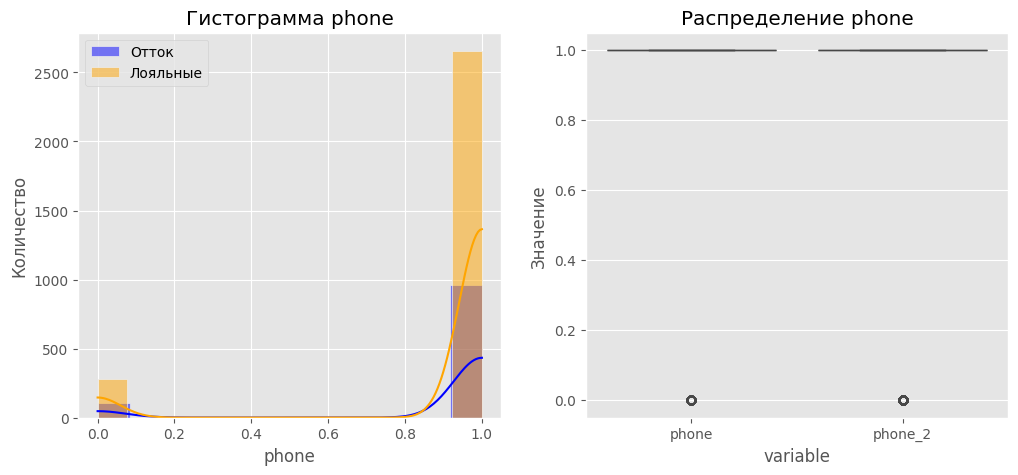

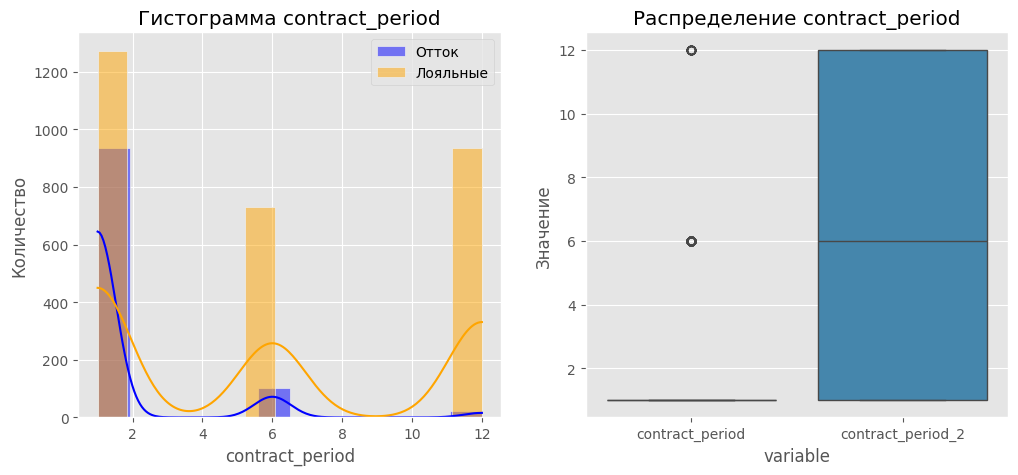

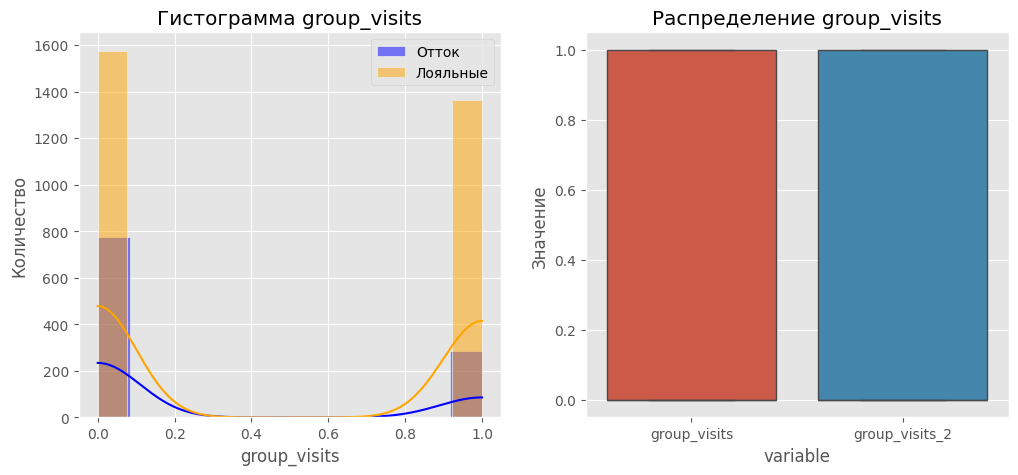

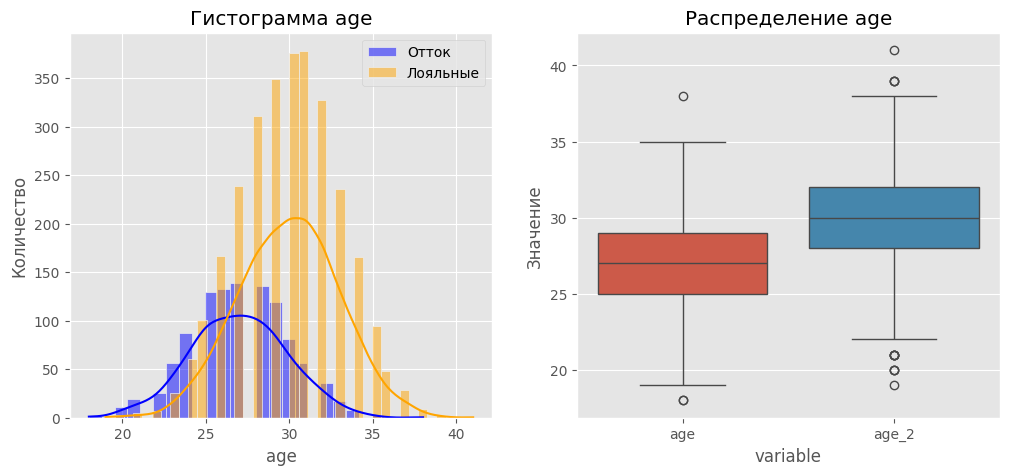

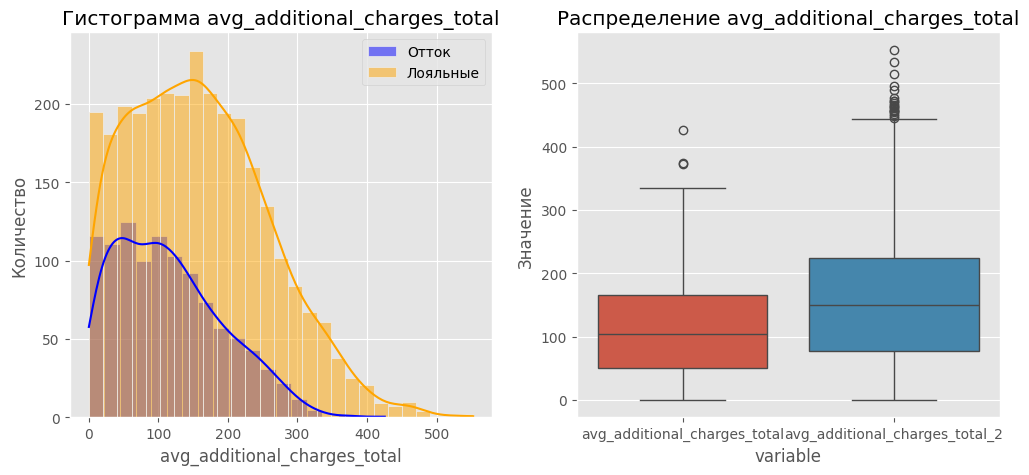

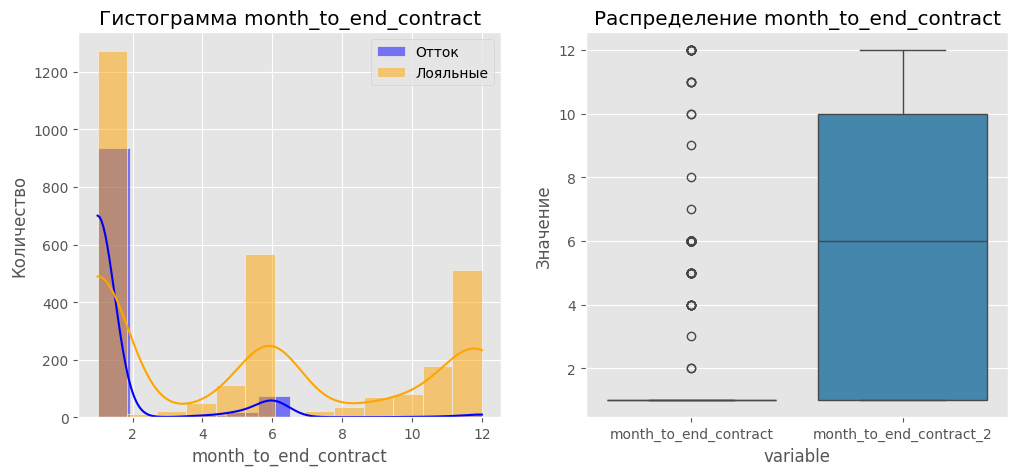

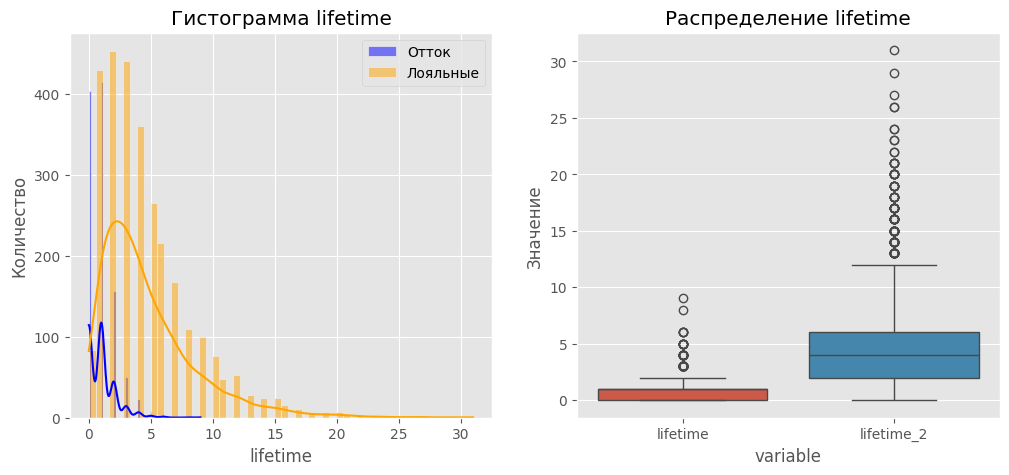

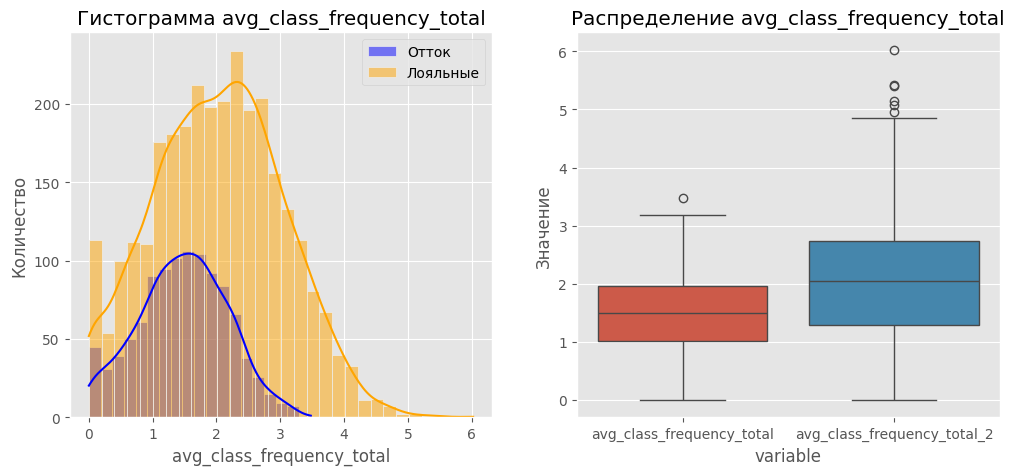

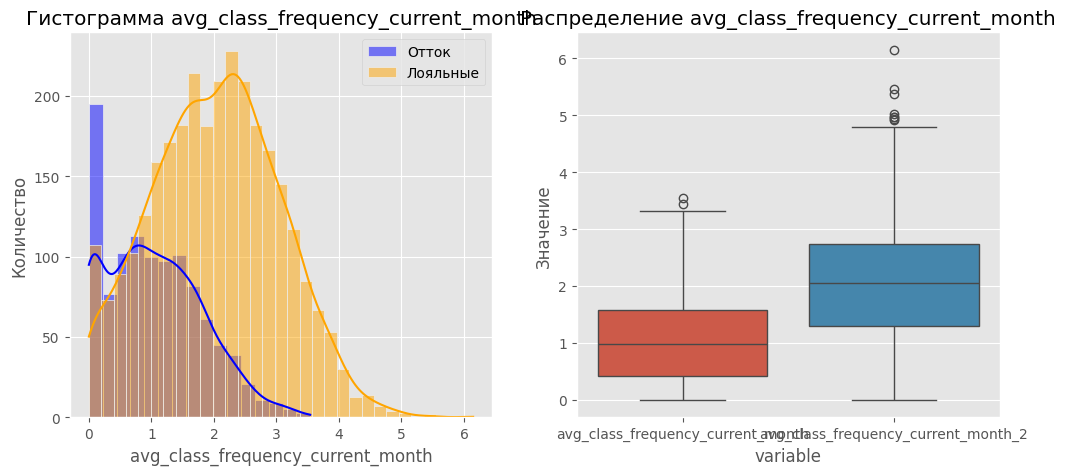

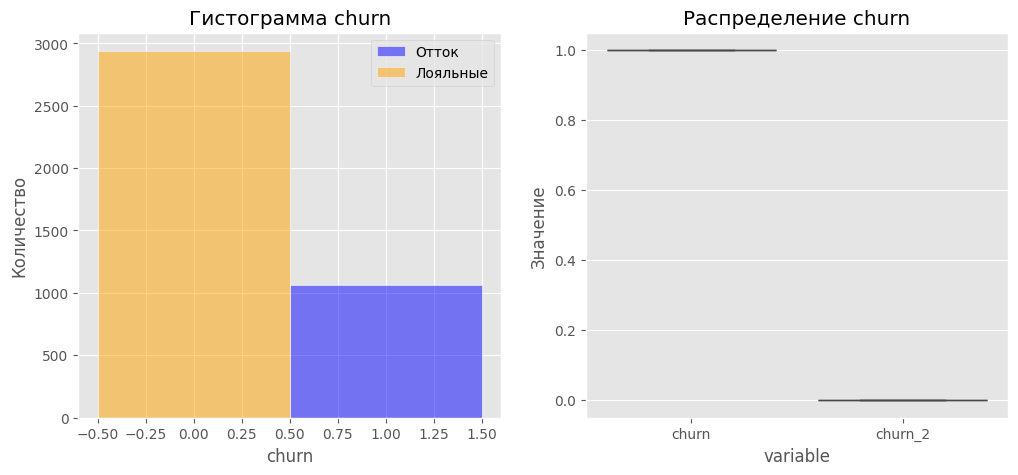

In [8]:
# Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
churned = gym_churn[gym_churn['churn'] == 1]
stayed = gym_churn[gym_churn['churn'] == 0]

def eda_compare(dataframe1, dataframe2, label1, label2):
    for column in dataframe1.columns:
        plt.figure(figsize=(12, 5))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(dataframe1[column], kde=True, color='blue', label=label1)
        sns.histplot(dataframe2[column], kde=True, color='orange', label=label2)
        plt.title(f'Гистограмма {column}')
        plt.ylabel('Количество')
        plt.legend()

        # Boxplot
        temp = dataframe2.rename(columns={column:column+'_2'})
        plt.subplot(1, 2, 2)
        sns.boxplot(x='variable', y='value', data=pd.melt(pd.concat([dataframe1[column], temp[column+'_2']], axis=1)), hue='variable')
        plt.title(f'Распределение {column}')
        plt.ylabel('Значение')

        plt.show()
    
eda_compare(churned, stayed, 'Отток', 'Лояльные')

In [9]:
# Построим матрицу корреляций и отобразим её.
cm = gym_churn.corr()

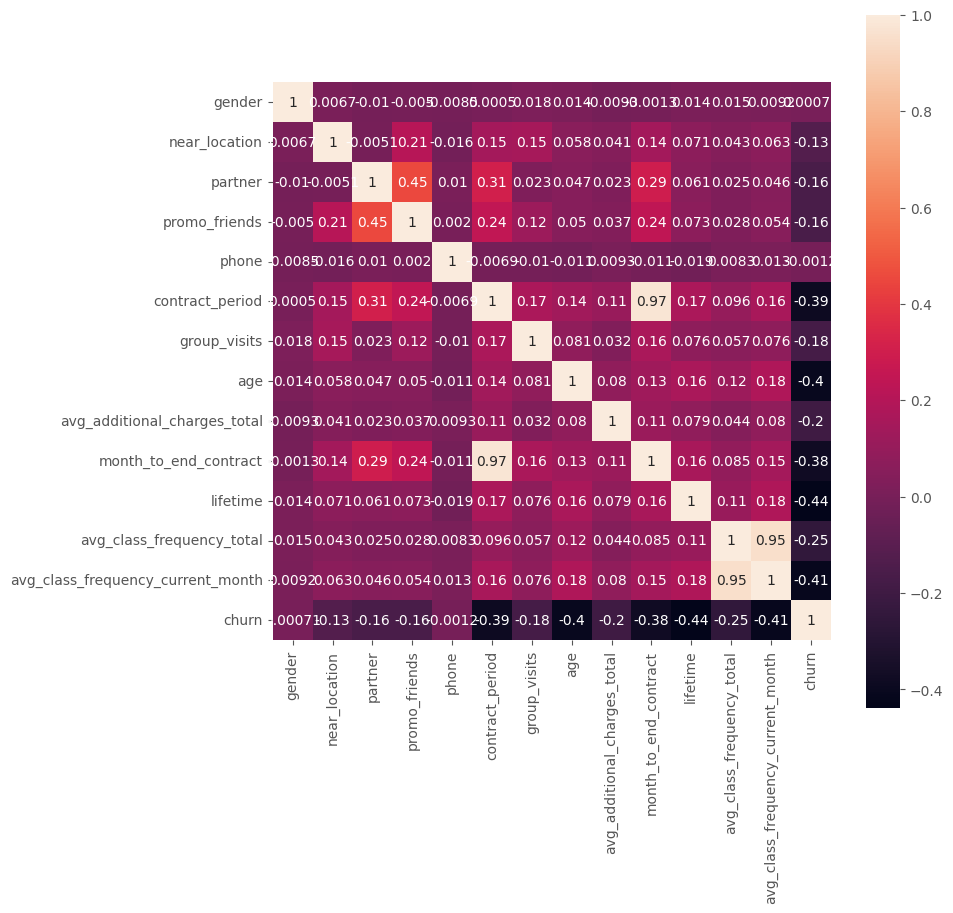

In [10]:
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, square=True) 
plt.show()

## предварительные итоги

- в датасете 4000 строк, пропусков нет.
- большинство признаков принимают значения 0 и 1
- в двух группах — тех, кто ушел в отток и тех, кто остался:
  - среднее значение периода контракта меньше у тех, кто ушёл
  - средний возраст ушедших - ниже
  - средняя частота посещений и выручка от доп. услуг меньше у ушедших
- Построили столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
- Построли матрицу корреляций.

<a id="model"></a>
# модель прогнозирования оттока клиентов

Пострим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:
- Разобьём данные на обучающую и валидационную выборку функцией `train_test_split()`.
- Обучим модель на train-выборке двумя способами:
  - логистической регрессией,
  - случайным лесом.
- Оценим метрики `accuracy`, `precision` и `recall` для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?

Зададим параметр `random_state` при разделении выборки и задании алгоритма.

In [11]:

# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop(columns=['churn'])
y = gym_churn['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# список моделей
models = [
    LogisticRegression(solver='liblinear'),
    RandomForestClassifier(n_estimators = 100, random_state = 0),
]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))


# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(solver='liblinear')
Accuracy: 0.93
Precision: 0.86
Recall: 0.83
RandomForestClassifier(random_state=0)
Accuracy: 0.92
Precision: 0.84
Recall: 0.82


- Accuracy: логистическая регрессия показала немного лучшие результаты.
- Precision: логистическая регрессия работала лучше.
- Recall: логистическая регрессия работала лучше.

Учитывая все три показателя, кажется, что модель логистической регрессии в этом случае превзошла классификатор случайного леса.

<a id="cluster"></a>
# Кластеризация клиентов

Отложим в сторону столбец с оттоком и проведём кластеризацию объектов (клиентов):
- Стандартизируем данные.
- Построим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.
- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договоримся за число кластеров принять `n=5`.
- Посмотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
Построим распределения признаков для кластеров. Можно ли что-то заметить по ним?
Для каждого полученного кластера посчитаем долю оттока (методом `groupby()`). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [12]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# передадим получившуюся стандартизированную таблицу в качестве параметра функции linkage(). 
# Чтобы диаграмма получилась показательной, лучше передать параметру method значение 'ward'
linked = linkage(X_sc, method = 'ward') 

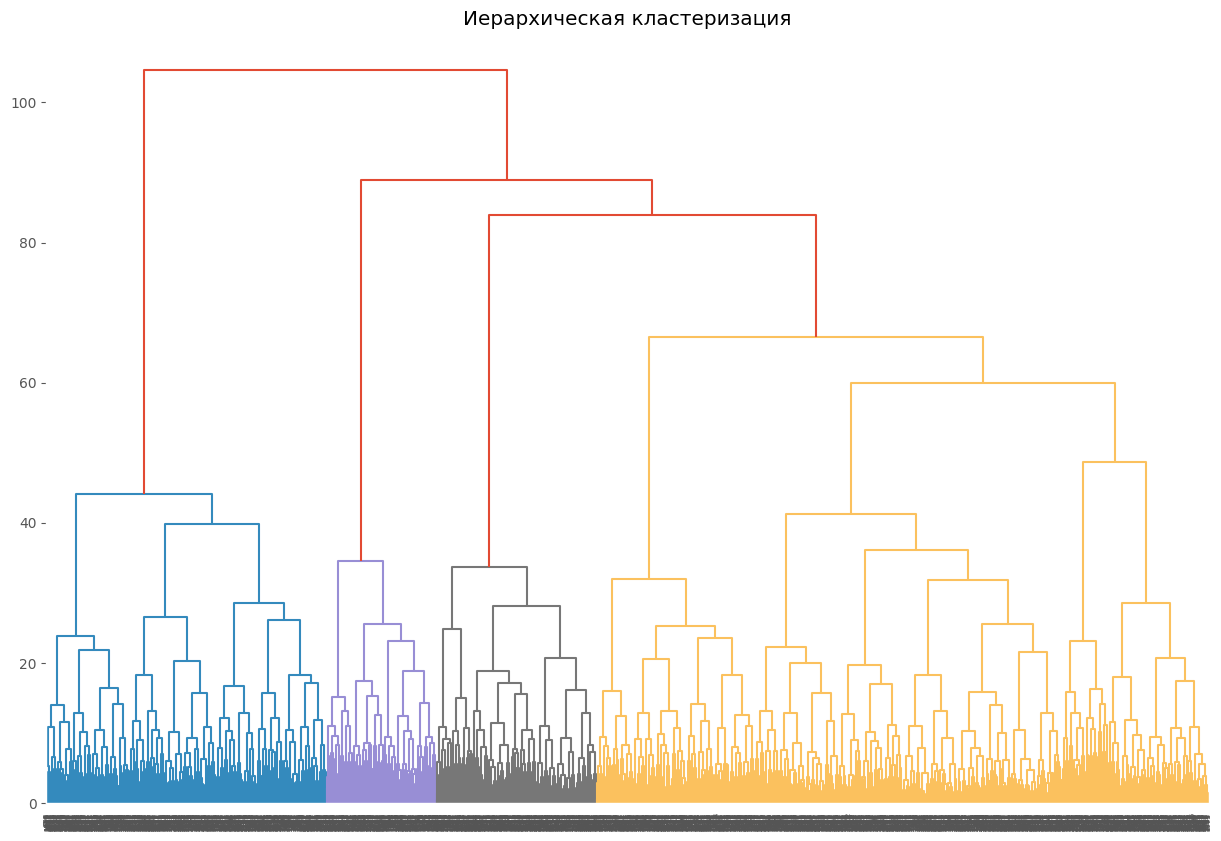

In [13]:
# В переменной linked сохранена таблица «связок» между объектами. Её можно визуализировать как дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

In [14]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
gym_churn.groupby('cluster_km').mean()

/Users/denis/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.5,0.0,0.5,0.1,0.9,2.2,0.2,28.5,133.9,2.1,2.8,1.7,1.5,0.4
1,0.6,1.0,0.3,0.1,0.9,2.8,0.5,30.1,162.0,2.6,5.1,2.9,2.9,0.1
2,0.5,1.0,0.8,1.0,0.9,3.2,0.5,29.2,141.2,2.9,3.7,1.7,1.6,0.2
3,0.5,0.9,0.7,0.5,0.9,11.9,0.6,29.9,164.8,10.9,4.7,2.0,2.0,0.0
4,0.5,1.0,0.2,0.0,0.9,2.0,0.3,28.2,131.2,1.9,2.4,1.3,1.0,0.5


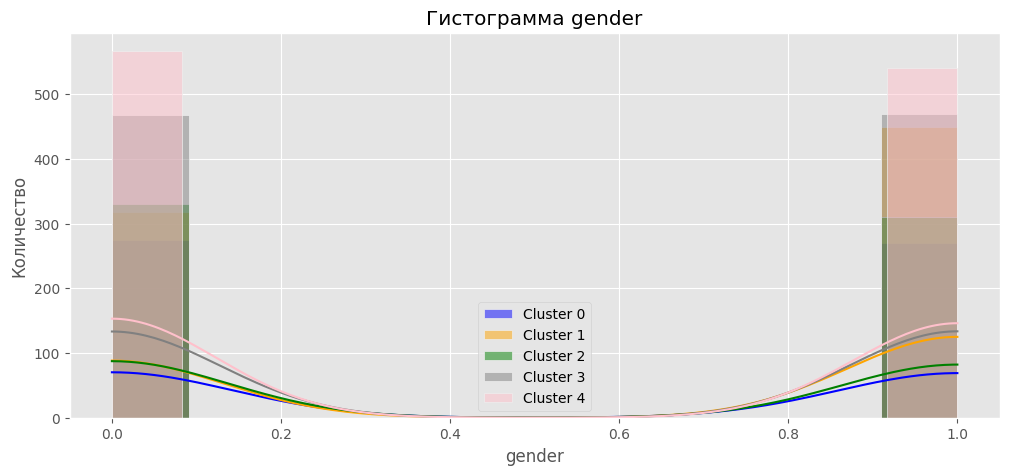

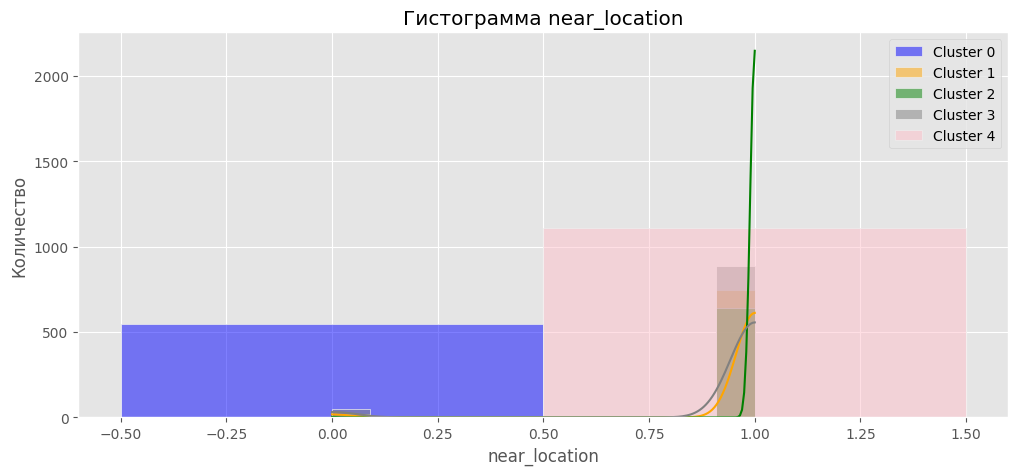

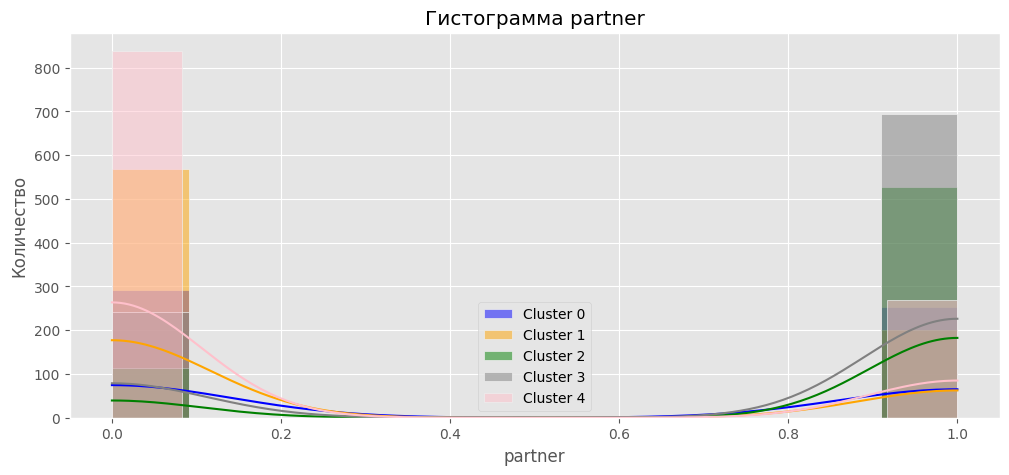

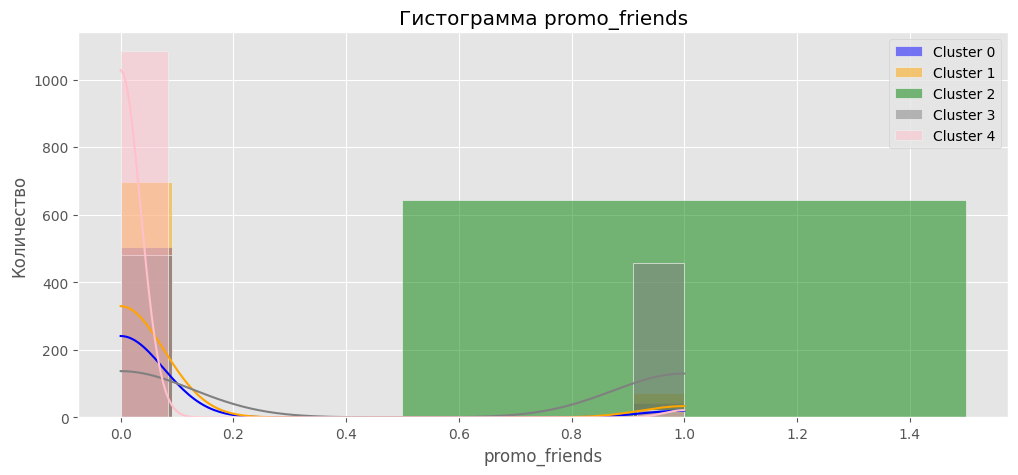

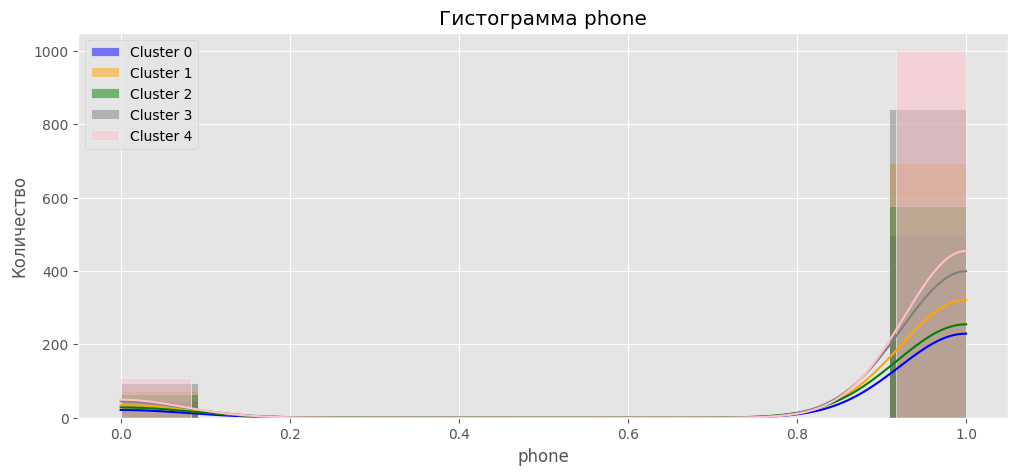

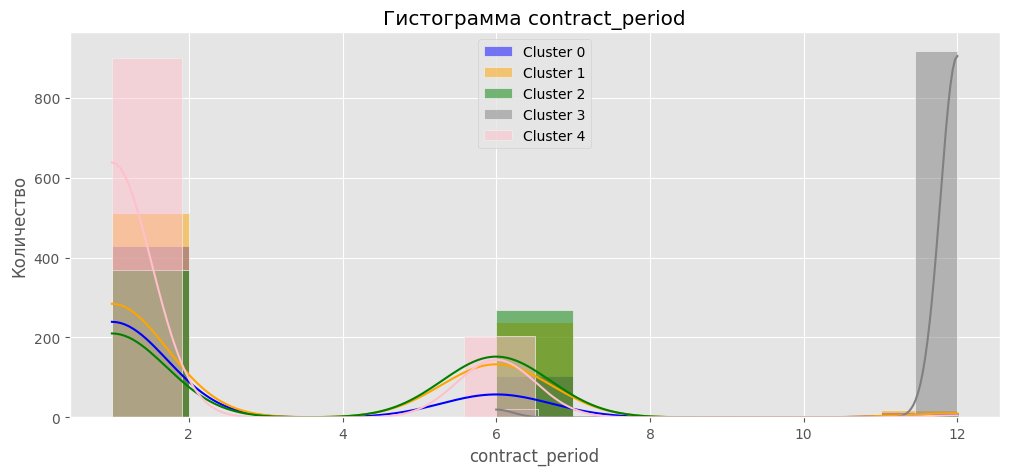

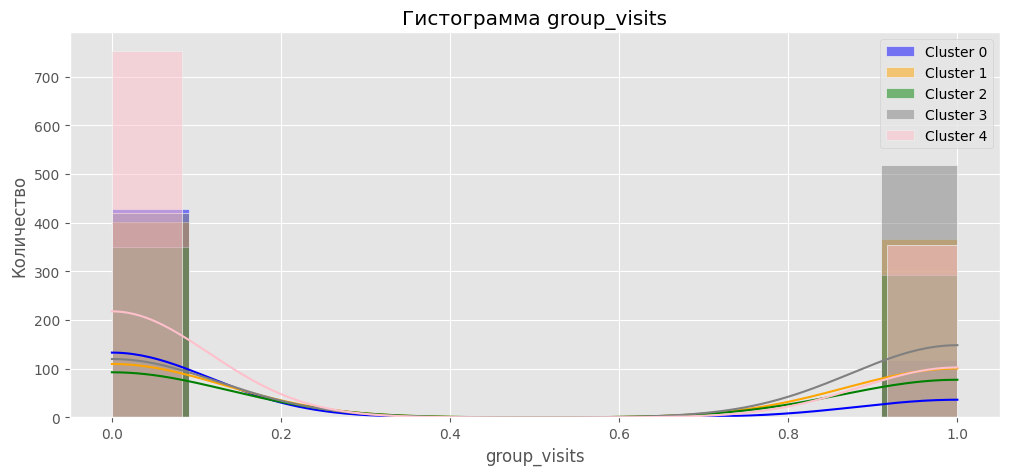

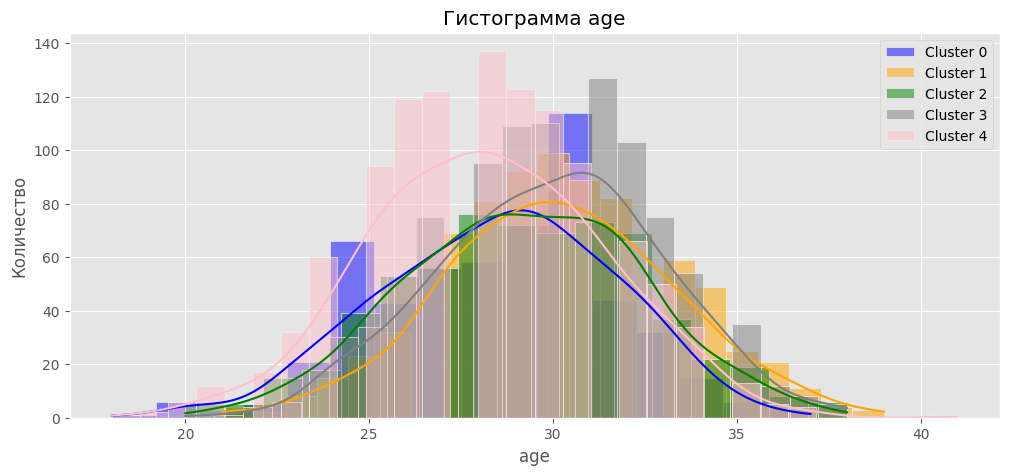

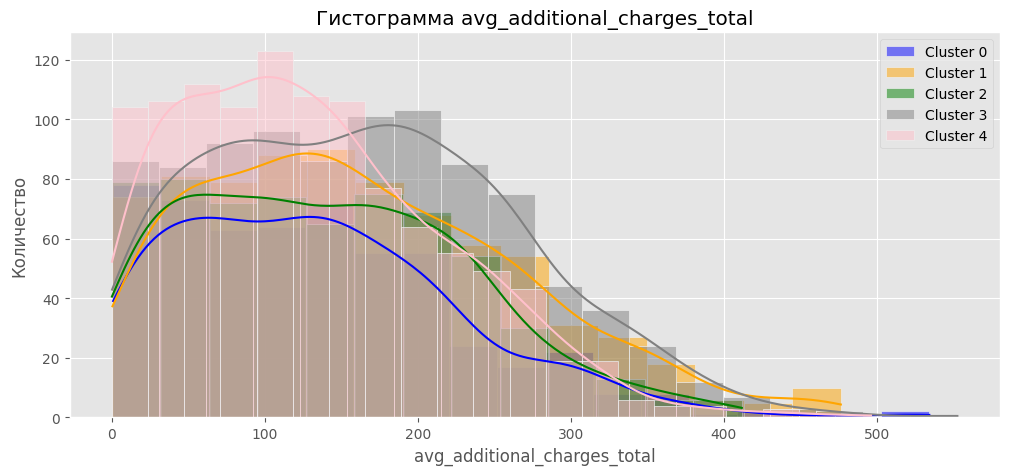

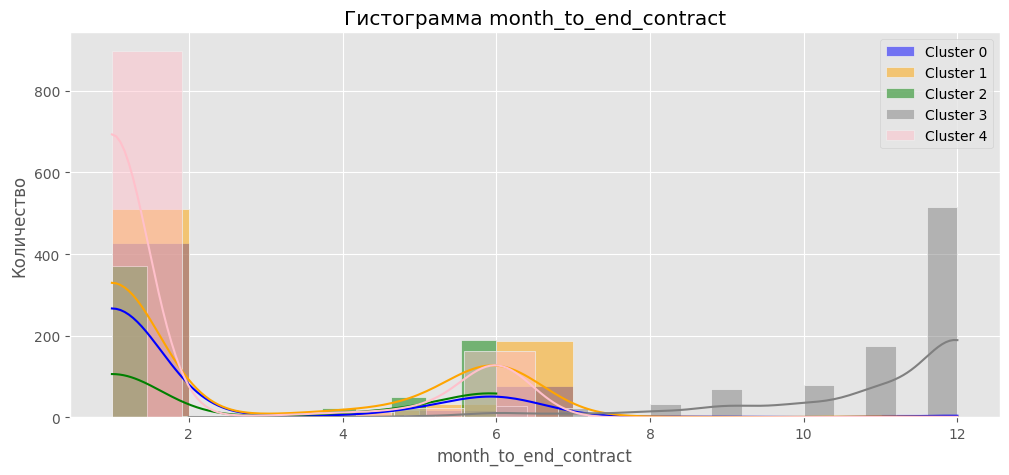

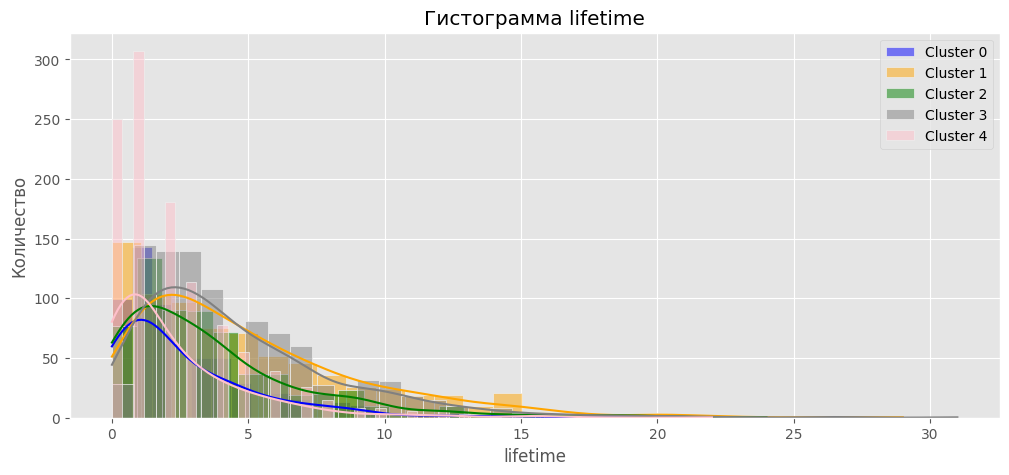

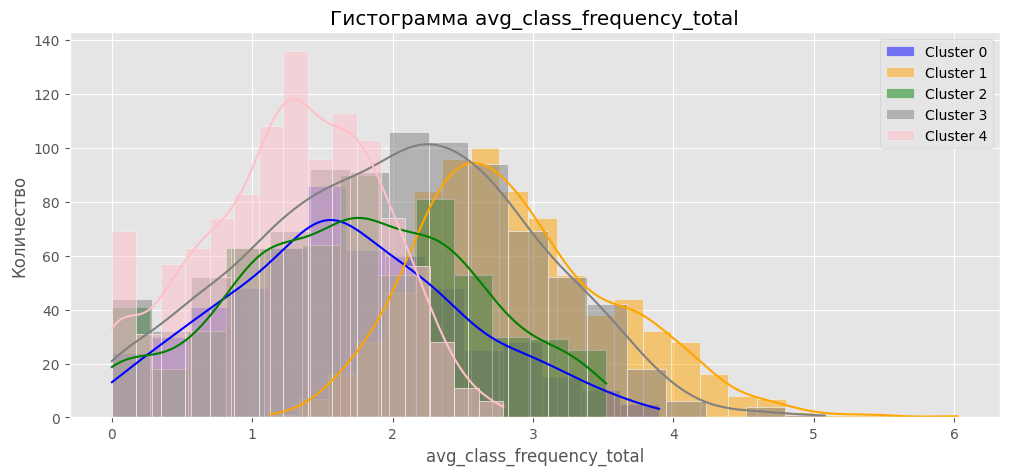

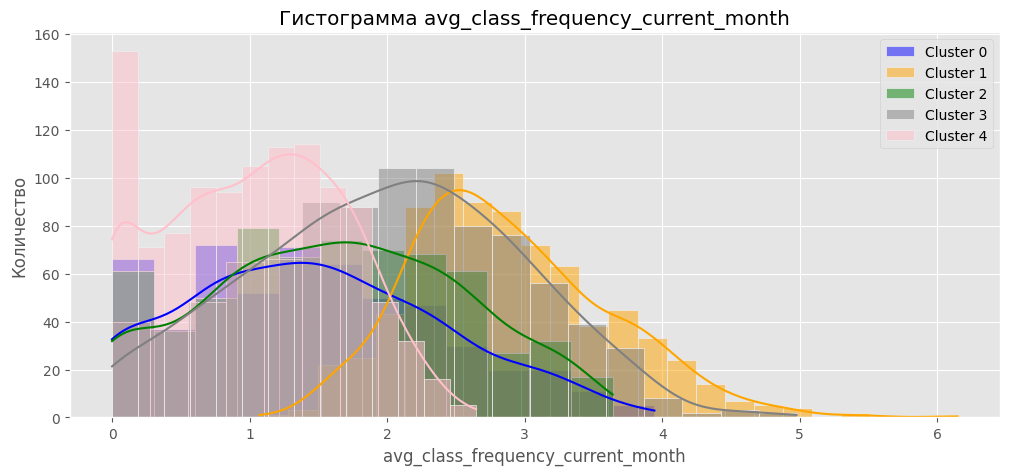

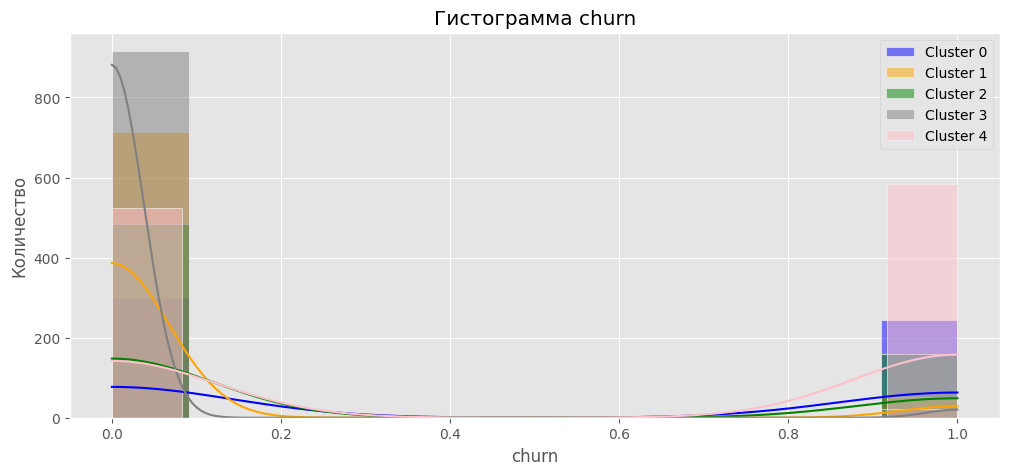

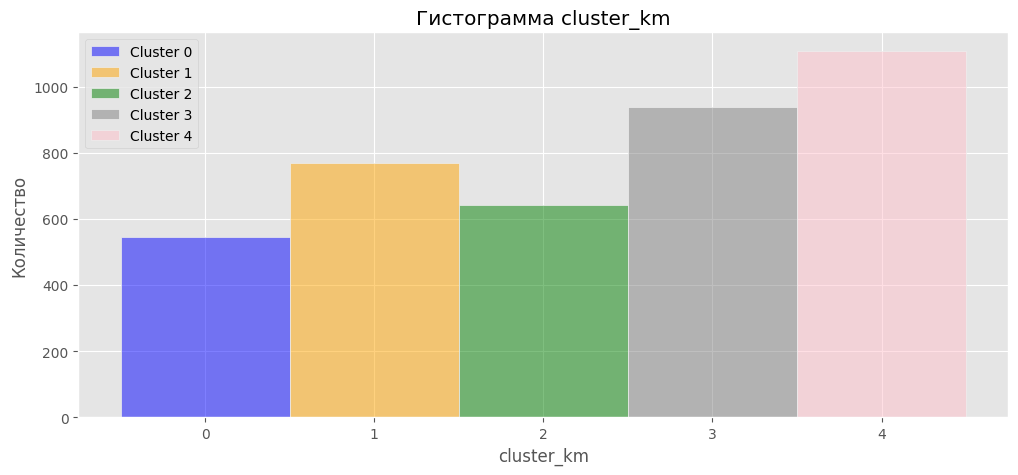

In [15]:
def clusters_compare(dataframe):
    dataframe1 = dataframe[dataframe['cluster_km'] == 0]
    dataframe2 = dataframe[dataframe['cluster_km'] == 1]
    dataframe3 = dataframe[dataframe['cluster_km'] == 2]
    dataframe4 = dataframe[dataframe['cluster_km'] == 3]
    dataframe5 = dataframe[dataframe['cluster_km'] == 4]
    
    for column in dataframe.columns:
        plt.figure(figsize=(12, 5))

        # Histogram
        sns.histplot(dataframe1[column], kde=True, color='blue', label='Cluster 0')
        sns.histplot(dataframe2[column], kde=True, color='orange', label='Cluster 1')
        sns.histplot(dataframe3[column], kde=True, color='green', label='Cluster 2')
        sns.histplot(dataframe4[column], kde=True, color='grey', label='Cluster 3')
        sns.histplot(dataframe5[column], kde=True, color='pink', label='Cluster 4')
        plt.title(f'Гистограмма {column}')
        plt.ylabel('Количество')
        plt.legend()

        plt.show()
    
clusters_compare(gym_churn)

- На распределении по `near_location` в кластере 0 преобладают значения 0, в кластерах 2 и 4 - значения 1
- На распределении по `partner` в кластере 1 и 4 преобладают значения 0, в кластерах 2 и 3 - значения 1
- На распределении по `promo_friends` в кластере 1 и 4 преобладают значения 0, в кластерах 2 и 3 - значения 1
- На распределении по `contract_period` в кластере 3 преобладают значения 12
- В распределении по возрасту есть смещение влево в кластере 4 (более молодые), у них также преобладает значение 0 в распределении `group_visits`
- 3 и 4 й кластеры лидируют по `avg_additional_charges_total`, кластер 0 отстаёт
- в 3м кластере осталось длительное время до истечения контракта, в 4м - малое
- В распределении по `avg_class_frequency_total` и `avg_class_frequency_current_month` есть смещение влево в кластере 4, клсатеры 3 и 1 смещены вправо
- 1 и 3 кластеры - churn ниже
- 4й кластер наиболее многочисленный

In [16]:
# Для каждого полученного кластера посчитаем долю оттока (методом `groupby()`)

churn_prc = gym_churn.groupby('cluster_km').agg(
    count = ('churn', 'count'),
    churn = ('churn', 'sum')
)

churn_prc['prc'] = churn_prc['churn']/churn_prc['count']
churn_prc

,count,churn,prc
cluster_km,,,
0,545,245,0.4
1,768,53,0.1
2,642,159,0.2
3,937,21,0.0
4,1108,583,0.5


- Наибольшая доля оттока в кластере 4
- Наименьшая - в кластере 3

## предварительные итоги

- Посмотрели на средние значения признаков для кластеров. 
- Построили распределения признаков для кластеров. 
  - На распределении по `near_location` в кластере 0 преобладают значения 0, в кластерах 2 и 4 - значения 1
  - На распределении по `partner` в кластере 1 и 4 преобладают значения 0, в кластерах 2 и 3 - значения 1
  - На распределении по `promo_friends` в кластере 1 и 4 преобладают значения 0, в кластерах 2 и 3 - значения 1
  - На распределении по `contract_period` в кластере 3 преобладают значения 12
  - В распределении по возрасту есть смещение влево в кластере 4 (более молодые), у них также преобладает значение 0 в распределении `group_visits`
  - 3 и 4 й кластеры лидируют по `avg_additional_charges_total`, кластер 0 отстаёт
  - в 3м кластере осталось длительное время до истечения контракта, в 4м - малое
  - В распределении по `avg_class_frequency_total` и `avg_class_frequency_current_month` есть смещение влево в кластере 4, клсатеры 3 и 1 смещены вправо
  - 1 и 3 кластеры - churn ниже
  - 4й кластер наиболее многочисленный
- Наибольшая доля оттока в кластере 4, наименьшая - в кластере 3

<a id="conclusion"></a>
# Выводы и базовые рекомендации по работе с клиентами

## Проделанная работа
- в датасете 4000 строк, пропусков нет.
- большинство признаков принимают значения 0 и 1
- в двух группах — тех, кто ушел в отток и тех, кто остался:
  - среднее значение периода контракта меньше у тех, кто ушёл
  - средний возраст ушедших - ниже
  - средняя частота посещений и выручка от доп. услуг меньше у ушедших
- Построили столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
- Построли матрицу корреляций

- научились прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента; модель логистической регрессии в этом случае превзошла классификатор случайного леса.

Метрики:
Accuracy: 0.93
Precision: 0.86
Recall: 0.83

- Посмотрели на средние значения признаков для кластеров. 
- Построили распределения признаков для кластеров. 

## 1. Выделим целевые группы клиентов:

### Группа 1: "Партнёры и долгосрочные контракты" (Кластер 3)

Часто являются сотрудниками компаний-партнёров.
Предпочитают контракты на 12 месяцев.
В этой группе наблюдается низкий уровень оттока.
Важно поддерживать сотрудничество с партнёрами и продвигать долгосрочные контракты.
### Группа 2: "Молодежь с высокой активностью" (Кластер 4)

Молодые клиенты с более низким возрастом.
Часто не используют групповые занятия, но активны в дополнительных услугах центра.
Склонны к короткосрочным контрактам.
Эта группа имеет наивысший уровень оттока. Важно разработать стратегию для удержания молодых клиентов, например, через привлекательные программы лояльности и акции.
### Группа 3: "Активные посетители среднего возраста" (Кластер 1)

Регулярно посещают занятия, в том числе групповые.
Средний возраст, более стабильные контракты.
Отток в этой группе низкий.
Важно поддерживать их активность и предлагать персонализированные программы тренировок.

## 2. Меры по снижению оттока:

Продвижение долгосрочных контрактов: Акцент на привлечении клиентов к долгосрочным контрактам, возможно, с бонусами или скидками для тех, кто заключает контракт на 6 или 12 месяцев.

Улучшение вовлечённости молодых клиентов: Разработка специальных программ и мероприятий для молодежи, включая интересные групповые тренировки, соревнования и социальные события.

Персонализированный подход: Анализ предпочтений клиентов и предоставление персонализированных тренировочных программ и рекомендаций.

Стимулирование активности в групповых занятиях: Продвижение и поощрение участия в групповых занятиях, например, через бонусы или скидки.

Мониторинг частоты посещений: Предупреждение клиентов о возможных последствиях нерегулярных тренировок и предложение индивидуальных планов поддержки.

## 3. Особенности взаимодействия с клиентами:

Контроль долгосрочных клиентов: Регулярная связь с клиентами с долгосрочными контрактами для поддержания их мотивации и интереса.

Мониторинг активности молодых клиентов: Систематический анализ активности молодых клиентов и оперативные меры по предотвращению оттока.

Повышение вовлечённости в групповые занятия: Организация интересных и разнообразных групповых тренировок, а также предоставление индивидуальных планов для тех, кто еще не участвует в них.

Поддержка среднего возраста: Предоставление дополнительных услуг, которые могут быть интересны этой группе, такие как индивидуальные консультации тренера или скидки на дополнительные услуги.

## Возможные основные признаки, влияющие на отток:

1. Длительность контракта (Contract_period):

Клиенты с короткосрочными контрактами могут быть более склонны к оттоку.

2. Время с момента первого обращения в фитнес-центр (Lifetime):

Клиенты с более длительным временем с момента первого обращения могут иметь более низкую вероятность оттока.

3. Средняя частота посещений в неделю за предыдущий месяц (Avg_class_frequency_current_month):

Клиенты, которые реже посещают занятия, вероятно, более подвержены оттоку.

4. Проживание или работа в районе, где находится фитнес-центр (Near_Location):

Клиенты, проживающие или работающие рядом с фитнес-центром, могут иметь более низкую вероятность оттока.

5. Участие в групповых занятиях (Group_visits):

Клиенты, участвующие в групповых занятиях, могут иметь более высокую лояльность.

6. Возраст (Age):

Молодые клиенты (25-30) или клиенты возраста (30-35) могут иметь различные паттерны оттока.

7. Суммарная выручка от дополнительных услуг (Avg_additional_charges_total):

Клиенты, которые чаще используют дополнительные услуги, могут быть более лояльными.